In [26]:
import numpy as np
import pandas as pd
import json

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

from matplotlib import pyplot as plt
import seaborn as sns

import itertools
import random

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import util

%matplotlib inline

## Pull Spotify Data

In [27]:
CLIENT_ID="810e2eec841546269c49f338f1be189a"
CLIENT_SECRET="764290d0ab0f4f4484b0d4c7b701bdee"

token = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

cache_token = token.get_access_token()
sp = spotipy.Spotify(cache_token)

In [28]:
# Pull data
TRACK_DATA_PATH = "data/tracks.json"
with open(TRACK_DATA_PATH,'r') as ff:
    songs = json.load(ff)
    
# Remove duplicates
songs.sort()
songs = list(s for s,_ in itertools.groupby(songs))
print("Loaded {} songs from {}".format(len(songs), TRACK_DATA_PATH))
print("First ten songs: {}".format(songs[:10]))

Loaded 6686 songs from data/tracks.json
First ten songs: [['002QT7AS6h1LAF5dla8D92', 'Still Smell Like It', 56], ['003eoIwxETJujVWmNFMoZy', 'Growing Pains', 72], ['00B7TZ0Xawar6NZ00JFomN', 'Best Life (feat. Chance The Rapper)', 70], ['00Fboe8pNoWHLg1nn3e7Oi', 'Sands Of Time (Single Version) - Remastered', 0], ['00GL3XaK1sBpnB2eaam9SG', 'Ghost Town', 42], ['00I0pcNkN3IOX3fsYbaB4N', 'Infatuation', 69], ['00KjOnN3U40e3lXFUOue7h', '10AM/Save The World (feat. Gucci Mane)', 61], ['00Y9yFHumsN6Cg4cK3wXkM', 'Cap (feat. Trouble) - From Jxmtro', 51], ['00bWqt93aqLXqKtzZoq7Jw', 'MOOO!', 69], ['00ix2WCV1QGcrcVGliKJYY', 'Photograph - Felix Jaehn Remix', 28]]


## Data Exploration

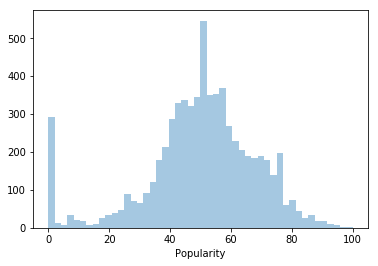

In [29]:
# Plot popularity distribution
sns.distplot([s[2] for s in songs], rug=False, kde=False, axlabel="Popularity")

In [30]:
# Extract top 5 most popular songs
sorted(songs, key=lambda song: song[2])[-10:]

[['2LskIZrCeLxRvCiGP8gxlh', 'Arms Around You (feat. Maluma & Swae Lee)', 94],
 ['3EPXxR3ImUwfayaurPi3cm', 'Be Alright', 94],
 ['3ee8Jmje8o58CHK66QrVC2', 'SAD!', 94],
 ['4S8d14HvHb70ImctNgVzQQ', 'I Love It (& Lil Pump)', 94],
 ['0d2iYfpKoM0QCKvcLCkBao', 'Eastside (with Halsey & Khalid)', 95],
 ['5N5k9nd479b1xpDZ4usjrg', 'Promises (with Sam Smith)', 95],
 ['2xLMifQCjDGFmkHkpNLD9h', 'SICKO MODE', 96],
 ['5p7ujcrUXASCNwRaWNHR1C', 'Without Me', 96],
 ['2dpaYNEQHiRxtZbfNsse99', 'Happier', 98],
 ['4w8niZpiMy6qz1mntFA5uM',
  'Taki Taki (with Selena Gomez, Ozuna & Cardi B)',
  100]]

## Feature Extraction

In [9]:
sp.audio_features(songs[0][0])

[{'danceability': 0.487,
  'energy': 0.789,
  'key': 8,
  'loudness': -3.69,
  'mode': 1,
  'speechiness': 0.044,
  'acousticness': 0.00947,
  'instrumentalness': 4.05e-06,
  'liveness': 0.189,
  'valence': 0.0564,
  'tempo': 150.007,
  'type': 'audio_features',
  'id': '7wBJfHzpfI3032CSD7CE2m',
  'uri': 'spotify:track:7wBJfHzpfI3032CSD7CE2m',
  'track_href': 'https://api.spotify.com/v1/tracks/7wBJfHzpfI3032CSD7CE2m',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7wBJfHzpfI3032CSD7CE2m',
  'duration_ms': 270715,
  'time_signature': 4}]

In [10]:
''' Returns a list of each track's audio features'''
def features(songs):
    all_feats = []
    ids = [song[0] for song in songs]
    # Spotify's audio_features can only return 50 songs at once
    for i in range(0, len(songs), 50):
        track_feats = sp.audio_features(ids[i:i+50])
        for j in range(len(track_feats)):
            track_feats[j]['name'] = songs[i+j][1]
            track_feats[j]['popularity'] = songs[i+j][2]
        all_feats.extend(track_feats)
    return all_feats

In [11]:
feats = features(songs)
feats[100]

{'danceability': 0.638,
 'energy': 0.367,
 'key': 4,
 'loudness': -7.906,
 'mode': 1,
 'speechiness': 0.0266,
 'acousticness': 0.84,
 'instrumentalness': 0,
 'liveness': 0.0999,
 'valence': 0.219,
 'tempo': 71.957,
 'type': 'audio_features',
 'id': '2VIPU72L6tIR4w8J8ap6Kp',
 'uri': 'spotify:track:2VIPU72L6tIR4w8J8ap6Kp',
 'track_href': 'https://api.spotify.com/v1/tracks/2VIPU72L6tIR4w8J8ap6Kp',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2VIPU72L6tIR4w8J8ap6Kp',
 'duration_ms': 217120,
 'time_signature': 4,
 'name': 'Mercy',
 'popularity': 75}

In [12]:
data = pd.DataFrame(feats)
data = data.sample(frac=1)
data.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,time_signature,track_href,type,uri,valence
7375,0.80400,https://api.spotify.com/v1/audio-analysis/3uxy...,0.537,200663,0.600,3uxyOfvxzjhzMKAOU5S6TZ,0.000000,11,0.1210,-7.528,0,Slow Down,45,0.4110,84.349,4,https://api.spotify.com/v1/tracks/3uxyOfvxzjhz...,audio_features,spotify:track:3uxyOfvxzjhzMKAOU5S6TZ,0.258
4541,0.00436,https://api.spotify.com/v1/audio-analysis/1C1O...,0.640,185947,0.497,1C1OBpwB6tRViTiWE2ZgNR,0.000000,10,0.0858,-7.111,0,DNA.,51,0.3550,139.924,4,https://api.spotify.com/v1/tracks/1C1OBpwB6tRV...,audio_features,spotify:track:1C1OBpwB6tRViTiWE2ZgNR,0.424
8671,0.18800,https://api.spotify.com/v1/audio-analysis/1SuV...,0.502,195880,0.901,1SuVJpFhGQOSBAB6VUpHYH,0.000049,7,0.2800,-4.467,1,The Boy With the Thorn In His Side - 2017 Master,54,0.0459,119.022,4,https://api.spotify.com/v1/tracks/1SuVJpFhGQOS...,audio_features,spotify:track:1SuVJpFhGQOSBAB6VUpHYH,0.821
599,0.75000,https://api.spotify.com/v1/audio-analysis/2tgQ...,0.536,224947,0.574,2tgQaL85WoRfgEa4hFQgrE,0.002770,7,0.1050,-6.705,1,Feathered Indians,65,0.0254,87.194,4,https://api.spotify.com/v1/tracks/2tgQaL85WoRf...,audio_features,spotify:track:2tgQaL85WoRfgEa4hFQgrE,0.877
3862,0.93900,https://api.spotify.com/v1/audio-analysis/0QbT...,0.782,84315,0.127,0QbTsXbzGOnxKW5PQFR39f,0.781000,7,0.1250,-20.939,1,summer nights.,61,0.6680,83.989,4,https://api.spotify.com/v1/tracks/0QbTsXbzGOnx...,audio_features,spotify:track:0QbTsXbzGOnxKW5PQFR39f,0.390


In [13]:
features = ["acousticness", "danceability", "energy", 
            "loudness", "speechiness", "tempo", "valence"]

In [14]:
train, test = train_test_split(data, test_size=0.15)
x_train, y_train = train[features], train["popularity"]
x_test, y_test = test[features], test["popularity"]
print("Training size: {}, Test size: {}".format(len(train), len(test)))

Training size: 8500, Test size: 1500


## Baseline (Linear Regression)

In [17]:
lin_mod = LinearRegression()
lin_mod.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [18]:
test_preds = lin_mod.predict(x_test)
print("Mean Squared Error: {}".format(mean_squared_error(test_preds, y_test)))
print("Variance Score: {}".format(r2_score(test_preds, y_test)))

Mean Squared Error: 67.99115776685458
Variance Score: -112.49328819396099


In [19]:
coeffs = dict(zip(features, lin_mod.coef_))
print("Model coefficients: {}".format(coeffs))

Model coefficients: {'acousticness': 0.15630271998958647, 'danceability': 4.043510358512564, 'energy': -1.0842767017857033, 'loudness': 0.03864707700303794, 'speechiness': -3.3099628374622294, 'tempo': -0.004667247329210432, 'valence': -0.7306622754990316}


## SVM 

In [22]:
svr = SVR(gamma='scale')
svr.fit(x_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [23]:
test_preds = svr.predict(x_test)
print("SVM Mean Squared Error: {}".format(mean_squared_error(test_preds, y_test)))
print("SVM Variance Score: {}".format(r2_score(test_preds, y_test)))

SVM Mean Squared Error: 69.73567112611396
SVM Variance Score: -134.34559581928067
